# Predicting chance of shooting a goal

In [348]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math

from matplotlib import pyplot as plt

from utils import create_dummy_df
from utils import run_logistic_regression
from utils import plot_correlation_matrix
from utils import calculate_confusion_matrix

sns.set()

In [349]:
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0


## Selecting data to be used for the firt model and making it applicable (dropping nan, resolving categorical features)

### Starting with location and type of the shot

In [350]:
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

df.head()

,play_id,event,secondaryType,st_x,st_y
4,2016020045_5,Shot,WristShot,71.0,-9.0
5,2016020045_6,Goal,Wraparound,88.0,-5.0
7,2016020045_8,Shot,WristShot,56.0,-7.0
11,2016020045_12,Shot,SlapShot,37.0,24.0
16,2016020045_17,Shot,WristShot,57.0,-20.0


In [351]:
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)
df.isna().sum()

play_id          0
secondaryType    0
st_x             0
st_y             0
goal             0
dtype: int64

In [352]:
cat_var_cols = ['secondaryType']
df_lst_data = create_dummy_df(df=df, cat_cols=cat_var_cols, dummy_na=True)
df_lst_data.drop(columns=['secondaryType_nan'], inplace=True)
df_lst_data.head()

,play_id,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot
4,2016020045_5,71.0,-9.0,0,0,0,0,0,0,1
5,2016020045_6,88.0,-5.0,1,0,0,0,0,1,0
7,2016020045_8,56.0,-7.0,0,0,0,0,0,0,1
11,2016020045_12,37.0,24.0,0,0,1,0,0,0,0
16,2016020045_17,57.0,-20.0,0,0,0,0,0,0,1


## Using this features in the first version of the model with no feature engineering yet.

In [353]:
features = ['st_x', 'st_y', 'secondaryType_Deflected',
        'secondaryType_SlapShot', 'secondaryType_SnapShot',
        'secondaryType_TipIn', 'secondaryType_Wraparound',
        'secondaryType_WristShot']

target = 'goal'

# function implemented in the utils.py
X_test, y_test, model, score = run_logistic_regression(df_lst_data, features, target, plot_cmatrix=False)

Score: 0.9060381743452907


#### Score looks amazingly good. 90% prediction are correct. BUT, score alone is not enough. To evaluate a classifier, a confusion matrix can provide much better insights:

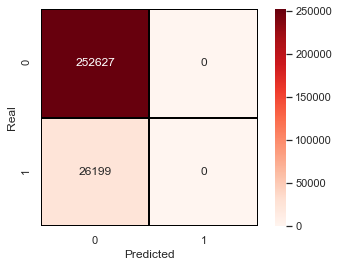

In [7]:
calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);

Sigmoid function: $$ S(y) = \frac{1}{1+e^{-y}} $$

#### And here we are!!! The model predicted **all values as 0, which is completely wrong**. If we replaced the model by a function with *return 0*, the result would be the same. That's why we need the confusion matrix!

## Next version with some feature engineering

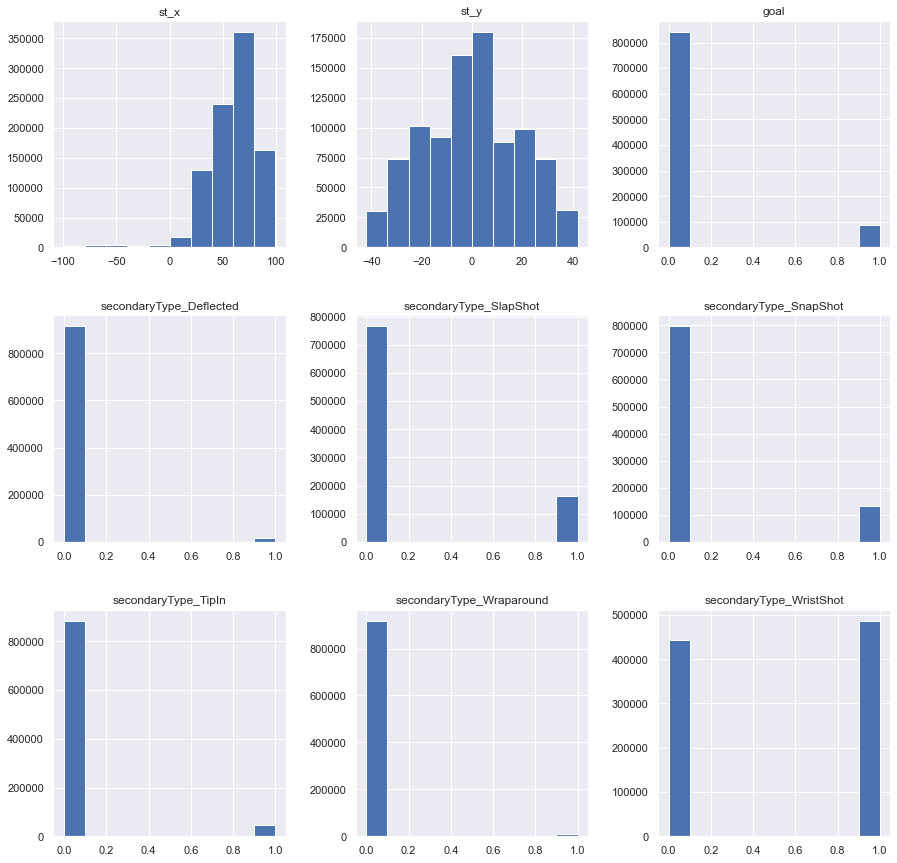

In [8]:
# checking data distribution of the predictive features
df_lst_data.hist(figsize=(15, 15));

#### First thing noticed is that we have much more targets with 1 than 0. This bias can fool the model. Let's use balanced model using same number of 0/1 as target (goal).

In [9]:
# taking all goals and a sample with the same size from shot without a goal
goals = df_lst_data[df_lst_data.goal==1]
no_goals = df_lst_data[df_lst_data.goal==0].sample(goals.shape[0], replace=False)
df_data = pd.concat([goals, no_goals])

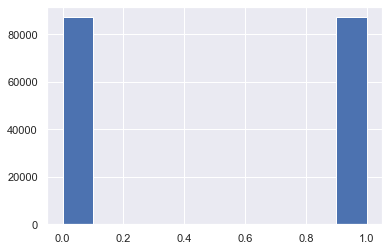

In [121]:
df_data.goal.hist();

In [10]:
# running the regression again with the same set of features
features = ['st_x', 'st_y', 'secondaryType_Deflected',
        'secondaryType_SlapShot', 'secondaryType_SnapShot',
        'secondaryType_TipIn', 'secondaryType_Wraparound',
        'secondaryType_WristShot']

target = 'goal'

# function implemented in the utils.py
X_test, y_test, model, score = run_logistic_regression(df_data, features, target, plot_cmatrix=False)

Score: 0.6318123602163898


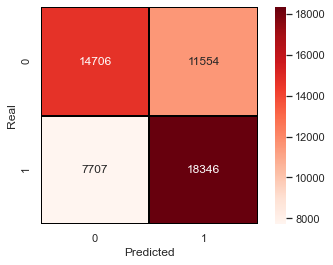

In [11]:
# The score is much lower (63%), what about the confusion matrix:
f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);

#### All right, much better now! We have 18254 true positives, and 14856 true negatives. We still have 11404 false positives (Type I) and 7799 false negatives (Type II). Let's combine the values from the confusion matrix and calculate F1-score.

In [12]:
f1

0.6557646596250425

Ideal value of f1-score is 1. This is not bad but let's try to do better. Let's do some quick experiments with features and/or other models

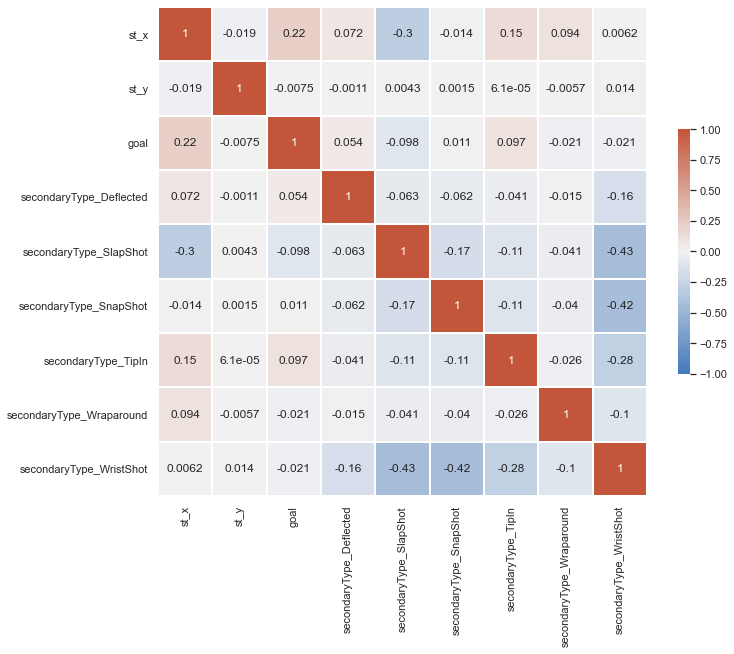

In [13]:
# Function implemented in utils.py
plot_correlation_matrix(df_data)

In [25]:
# use just 3 most correlated features
features = ['st_x', 'secondaryType_SlapShot', 'secondaryType_TipIn']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test));
print(f'F1-score: {f1}')

Score: 0.6290023512320073
F1-score: 0.6552385689416278


Score: 0.6306654177737847
F1-score: 0.6639884523747412


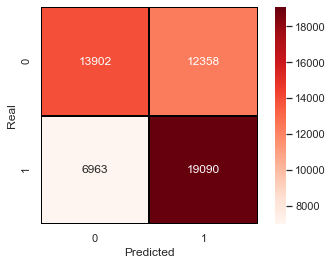

In [27]:
# use just the most correlated feature, which is st_x
features = ['st_x']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);
print(f'F1-score: {f1}')

We have higher F1 score but also higher Type I error (false positive). Let's engineer some new features

## Engineering distance as predictive feature

In [47]:
#visualize 3 shots to understand the coordinates system
df_data[:3]

,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot
5,88.0,-5.0,1,0,0,0,0,1,0
96,76.0,-1.0,1,0,0,0,0,0,0
102,67.0,28.0,1,0,1,0,0,0,0


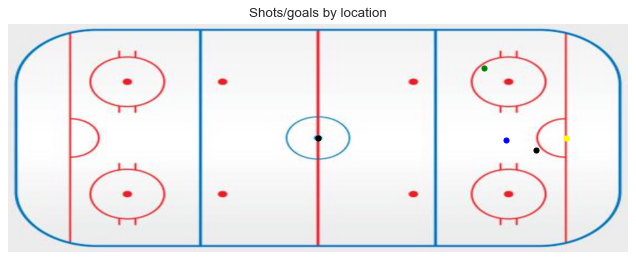

In [50]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/nhl/nhl_stats/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
#plt.scatter(df_data[:2].st_x, df_data[:2].st_y, s=20, c='black');
plt.scatter([0], [0], s=20, c='black');
plt.scatter([88], [-5], s=20, c='black');
plt.scatter([76], [-1], s=20, c='blue');
plt.scatter([67], [28], s=20, c='green');
plt.scatter([100], [0], s=20, c='yellow');

plt.title('Shots/goals by location');

Middle of the field is [0, 0]. Middle of the goal is [100, 0].

In [56]:
middle_goal_x = 100 
middle_goal_y = 0

In [58]:
# distance from the middle of the field
math.hypot(middle_goal_x - 0, middle_goal_y - 0)

100.0

In [59]:
# distance from the black dot [88, -5]
math.hypot(middle_goal_x - 88, middle_goal_y - (-5))

13.0

In [61]:
# distance from the blue dot [76, -1]
math.hypot(middle_goal_x - 76, middle_goal_y - (-1))

24.020824298928627

In [62]:
# distance from the green dot [67, 28]
math.hypot(middle_goal_x - 67, middle_goal_y - 28)

43.278170016764804

### using distance as predictive feature

In [67]:
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data['distance'] = df_data.apply(dist, axis=1)

In [69]:
df_data.head()

,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance
5,88.0,-5.0,1,0,0,0,0,1,0,13.000000
96,76.0,-1.0,1,0,0,0,0,0,0,24.020824
102,67.0,28.0,1,0,1,0,0,0,0,43.278170
139,83.0,-11.0,1,0,0,0,0,0,0,20.248457
196,76.0,11.0,1,0,0,0,0,0,1,26.400758


In [70]:
# looks like the values are correct

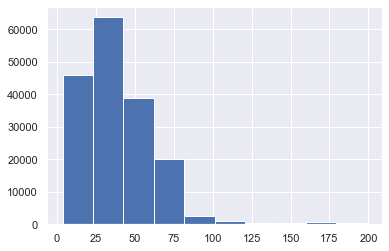

In [72]:
df_data.distance.hist();

In [73]:
df_data_dist = df_data[df_data.distance<80]

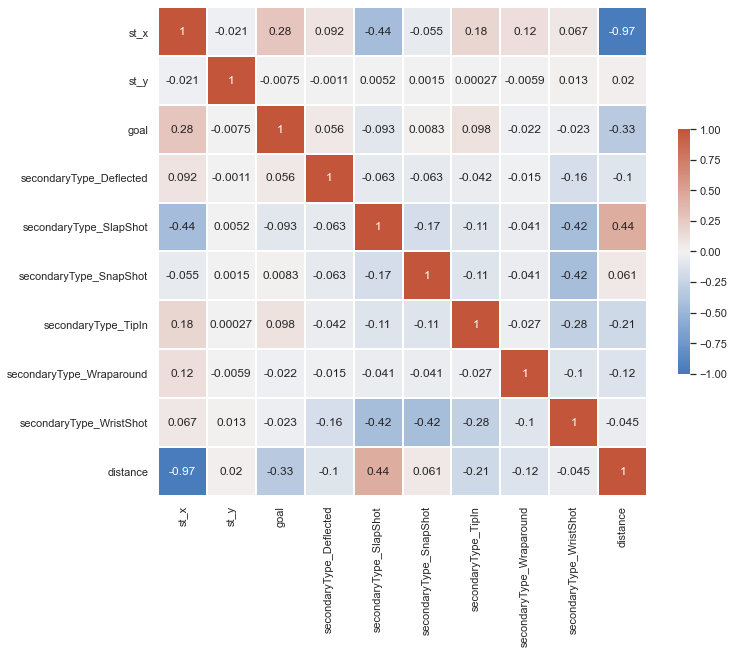

In [75]:
plot_correlation_matrix(df_data_dist)

Distance looks to be pretty correlated with goal. Best correlation so far.

In [129]:
# use just 2 most correlated features, "X" and the new feature "distance"
features = ['st_x', 'distance']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data_dist, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test));
print(f'F1-score: {f1}')

Score: 0.6688157582469741
F1-score: 0.6899807464454976


#### Significant improvement. We're getting there.... Let's try angle instead of st_x

## Engineering angle as predictive feature

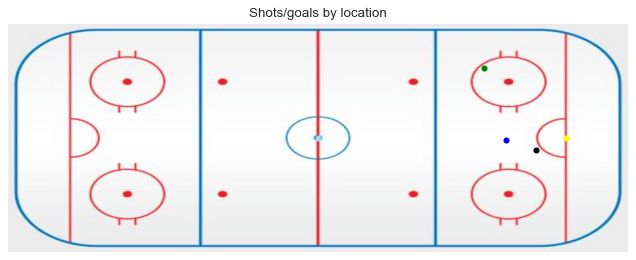

In [96]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/nhl/nhl_stats/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
#plt.scatter(df_data[:2].st_x, df_data[:2].st_y, s=20, c='black');
plt.scatter([0], [0], s=20, c='lightblue');
plt.scatter([88], [-5], s=20, c='black');
plt.scatter([76], [-1], s=20, c='blue');
plt.scatter([67], [28], s=20, c='green');
plt.scatter([100], [0], s=20, c='yellow');

plt.title('Shots/goals by location');

In [79]:
# First we need to place the middle of the coordinates to the middle of the goal: 'y = y', 'x = x-100'
# The line from the middle of the goal to the middle of the field should be 0 degree. 
# Using ata2, we need to convert to dergees and add 90 degrees to recalibrate to the middle of the field.

In [98]:
# try on the lightblue dot, middle of the field (0, 0)
math.degrees(math.atan2(-100, 0)) + 90

0.0

In [93]:
# try on the black dot (88, -5)
math.degrees(math.atan2(-12, -5)) + 90

-22.61986494804043

In [94]:
# try on the blue dot (76, -1)
math.degrees(math.atan2(-24, -1)) + 90

-2.3859440303888277

In [95]:
# try on the green dot (67, 28)
math.degrees(math.atan2(-33, 28)) + 90

40.3141001604973

This looks like the angles make sense. Let's add it to the dataframe

In [105]:
def angle(df):     
    middle_goal_x = 100 
    return math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)
df_data_dist_angle.head()

,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle
5,88.0,-5.0,1,0,0,0,0,1,0,13.000000,-22.619865
96,76.0,-1.0,1,0,0,0,0,0,0,24.020824,-2.385944
102,67.0,28.0,1,0,1,0,0,0,0,43.278170,40.314100
139,83.0,-11.0,1,0,0,0,0,0,0,20.248457,-32.905243
196,76.0,11.0,1,0,0,0,0,0,1,26.400758,24.623565


### using angle in the model

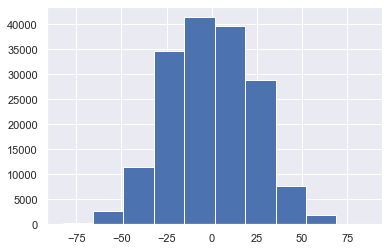

In [107]:
df_data_dist_angle.angle.hist();

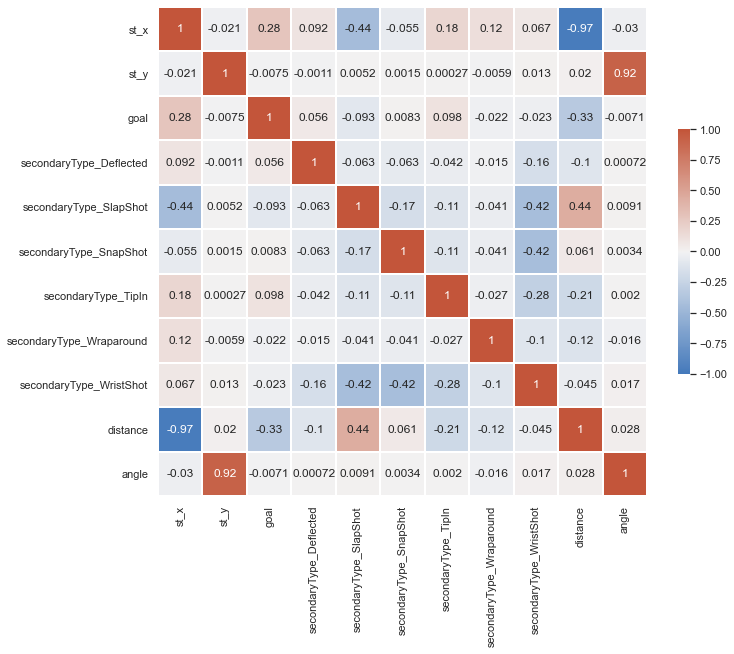

In [109]:
plot_correlation_matrix(df_data_dist_angle)

#### Angle doesn't look to be very correlated to the goal, let's add it anyway and see the impact on the f1-score.

In [128]:
# use just 2 most correlated features, "X" and the new feature "distance"
features = ['st_x', 'distance', 'angle']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data_dist_angle, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test));
print(f'F1-score: {f1}')

Score: 0.6687168736650582
F1-score: 0.6898020407029499


#### As expected, the impact of the feature *angle* is extremely low. 0.6827 (w/ angle) vs. 0.6826 (w/o angle). This means that distance is much more important in predicting the scoring of the goal than the angle. 

### Using 4 most correlated features, we achieved the best score:

Score: 0.6701210347282651
F1-score: 0.6896513228891452


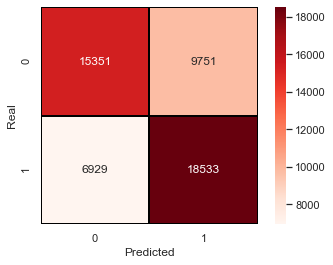

In [130]:
features = ['st_x', 'distance', 'secondaryType_SlapShot', 'secondaryType_TipIn']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data_dist_angle, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);
print(f'F1-score: {f1}')

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [209]:
def test_logistic_regression(df_data, lst_features, target, plot_cmatrix=False, max_iter = 10000):
    '''
    INPUT:
    df_data - data frame with data used for the logistic regression
    lst_features - list of predictive features used in the model
    target - target to be predicted
    
    OUTPUT:
    model - trained logistic regression model
    '''    
    
    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(df_data[lst_features], df_data[target], test_size=0.3, random_state=42)

    model = LogisticRegression(penalty='l2', tol=0.0001, 
                           C=1, fit_intercept=True, intercept_scaling=2.0, 
                           class_weight=None, random_state=42, max_iter=max_iter)
    model.fit(X_train, y_train)

    # use model score
    score = model.score(X_test, y_test)
    
    print(f'Score: {score}')
    
    return X_test, y_test, model, score

Score: 0.6688157582469741
F1-score: 0.6899807464454976


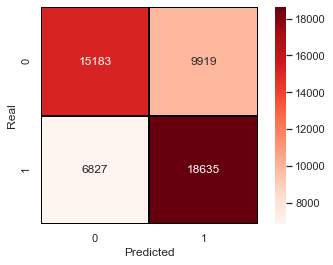

In [210]:
features = ['st_x', 'distance']
target = 'goal'

X_test, y_test, model, score = test_logistic_regression(df_data_dist_angle, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);
print(f'F1-score: {f1}')

# Players

In [242]:
df_player_stats = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [243]:
df_game_play_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_game_play_player.head()

,play_id,game_id,player_id,playerType
0,2016020045_4,2016020045,8473604,Winner
1,2016020045_4,2016020045,8473512,Loser
2,2016020045_5,2016020045,8473573,Shooter
3,2016020045_5,2016020045,8473607,Goalie
4,2016020045_6,2016020045,8474141,Scorer


In [244]:
df_game_play_player.playerType.value_counts()

Shooter      1634308
Goalie        990290
Winner        894041
Loser         894041
Hitter        706098
Hittee        706098
PlayerID      485171
Blocker       431926
PenaltyOn     247733
Assist        245702
DrewBy        198271
Scorer        148992
ServedBy        3021
Unknown          912
Name: playerType, dtype: int64

In [245]:
# we need shooters and scorers only
df_game_play_player = df_game_play_player[df_game_play_player.playerType.isin(['Shooter', 'Scorer'])]

In [246]:
df_merged = df.merge(df_game_play_player, how='left', on='play_id').drop_duplicates()
df_merged

,play_id,event,secondaryType,st_x,st_y,game_id,player_id,playerType
0,2016020045_5,Shot,WristShot,71.0,-9.0,2016020045,8473573,Shooter
1,2016020045_6,Goal,Wraparound,88.0,-5.0,2016020045,8474141,Scorer
2,2016020045_8,Shot,WristShot,56.0,-7.0,2016020045,8474668,Shooter
3,2016020045_12,Shot,SlapShot,37.0,24.0,2016020045,8470281,Shooter
4,2016020045_17,Shot,WristShot,57.0,-20.0,2016020045,8474190,Shooter
...,...,...,...,...,...,...,...,...
1254149,2018030417_277,Goal,SnapShot,77.0,-7.0,2018030417,8477482,Scorer
1254151,2018030417_280,Shot,SnapShot,69.0,-7.0,2018030417,8470257,Shooter
1254153,2018030417_281,Shot,SnapShot,65.0,4.0,2018030417,8475158,Shooter
1254155,2018030417_285,Shot,WristShot,42.0,3.0,2018030417,8475149,Shooter


In [247]:
df_merged.playerType.value_counts()

Shooter    695439
Scorer      71557
Name: playerType, dtype: int64

In [248]:
df_merged.event.value_counts()

Shot    695439
Goal     71557
Name: event, dtype: int64

This ^^ makes absolutelly sense. #Score == #Goal and #Shooter = #Shot

In [250]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')
df_player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


In [251]:
df_temp = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_temp

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2016020045,8468513,4,955,1,0,0,2.0,0,0,...,0,1.0,1.0,0,0,1.0,1,858,97,0
1,2016020045,8476906,4,1396,1,0,4,2.0,0,0,...,0,1.0,2.0,0,0,2.0,0,1177,0,219
2,2016020045,8474668,4,915,0,0,1,1.0,0,0,...,0,2.0,0.0,0,0,0.0,-1,805,0,110
3,2016020045,8473512,4,1367,3,0,0,0.0,0,2,...,27,0.0,0.0,0,0,0.0,-1,1083,19,265
4,2016020045,8471762,4,676,0,0,3,2.0,0,0,...,0,0.0,1.0,0,0,0.0,-1,613,63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945825,2018030417,8475807,6,501,0,0,1,2.0,0,0,...,0,0.0,0.0,0,0,0.0,-1,501,0,0
945826,2018030417,8475149,6,1062,0,0,2,0.0,0,0,...,1,1.0,0.0,0,0,0.0,-1,957,0,105
945827,2018030417,8475745,6,913,0,0,2,3.0,0,0,...,11,1.0,0.0,0,0,0.0,0,913,0,0
945828,2018030417,8478443,6,1006,0,0,1,1.0,0,0,...,0,0.0,1.0,0,0,2.0,-1,1006,0,0


In [256]:
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [266]:
df_player_stats.rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality'}, inplace=True)


In [270]:
df_merged = df_merged.merge(df_player_info[['player_id', 'firstName', 'lastName', 'nationality']], how='left', on='player_id')
df_merged

,play_id,event,secondaryType,st_x,st_y,game_id,player_id,playerType,firstName,lastName,nationality
0,2016020045_5,Shot,WristShot,71.0,-9.0,2016020045,8473573,Shooter,Artem,Anisimov,RUS
1,2016020045_6,Goal,Wraparound,88.0,-5.0,2016020045,8474141,Scorer,Patrick,Kane,USA
2,2016020045_8,Shot,WristShot,56.0,-7.0,2016020045,8474668,Shooter,Dale,Weise,CAN
3,2016020045_12,Shot,SlapShot,37.0,24.0,2016020045,8470281,Shooter,Duncan,Keith,CAN
4,2016020045_17,Shot,WristShot,57.0,-20.0,2016020045,8474190,Shooter,Wayne,Simmonds,CAN
...,...,...,...,...,...,...,...,...,...,...,...
766991,2018030417_277,Goal,SnapShot,77.0,-7.0,2018030417,8477482,Scorer,Zach,Sanford,USA
766992,2018030417_280,Shot,SnapShot,69.0,-7.0,2018030417,8470257,Shooter,Alexander,Steen,SWE
766993,2018030417_281,Shot,SnapShot,65.0,4.0,2018030417,8475158,Shooter,Ryan,O'Reilly,CAN
766994,2018030417_285,Shot,WristShot,42.0,3.0,2018030417,8475149,Shooter,Marcus,Johansson,SWE


In [271]:
df_merged = df_merged.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])


In [272]:
df_merged

,play_id,event,secondaryType,st_x,st_y,game_id,player_id,playerType,firstName,lastName,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,2016020045_5,Shot,WristShot,71.0,-9.0,2016020045,8473573,Shooter,Artem,Anisimov,...,54.0,4.2,1.4,5.6,2544.57,75.0,3.5,110.1,39.1,0.61
1,2016020045_6,Goal,Wraparound,88.0,-5.0,2016020045,8474141,Scorer,Patrick,Kane,...,91.0,8.7,2.1,10.8,3057.71,75.0,4.8,114.0,89.2,1.09
2,2016020045_8,Shot,WristShot,56.0,-7.0,2016020045,8474668,Shooter,Dale,Weise,...,41.0,0.2,1.1,1.3,2474.29,201.0,24.7,104.5,23.2,0.36
3,2016020045_12,Shot,SlapShot,37.0,24.0,2016020045,8470281,Shooter,Duncan,Keith,...,111.0,4.0,5.5,9.5,2774.72,147.0,7.0,112.4,54.0,0.67
4,2016020045_17,Shot,WristShot,57.0,-20.0,2016020045,8474190,Shooter,Wayne,Simmonds,...,117.0,5.1,1.2,6.3,3373.26,350.0,6.5,123.0,53.1,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766991,2018030417_277,Goal,SnapShot,77.0,-7.0,2018030417,8477482,Scorer,Zach,Sanford,...,27.0,0.1,0.5,0.7,1607.84,52.0,7.2,103.3,6.7,NaN
766992,2018030417_280,Shot,SnapShot,69.0,-7.0,2018030417,8470257,Shooter,Alexander,Steen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766993,2018030417_281,Shot,SnapShot,65.0,4.0,2018030417,8475158,Shooter,Ryan,O'Reilly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766994,2018030417_285,Shot,WristShot,42.0,3.0,2018030417,8475149,Shooter,Marcus,Johansson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
df_merged.describe()

,st_x,st_y,game_id,player_id,Salary,Ht,Wt,DftYr,DftRd,Ovrl,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
count,766996.000000,766996.000000,7.669960e+05,7.669960e+05,4.245800e+05,424580.000000,424580.000000,388988.000000,388988.000000,388988.000000,...,424579.000000,424580.000000,424580.000000,424580.000000,424579.000000,424580.000000,424580.000000,424579.000000,424579.000000,424348.000000
mean,59.383814,-0.112144,2.014665e+09,8.473261e+06,3.858017e+06,73.032604,202.229003,2007.325902,2.330581,54.048045,...,68.249157,2.655697,1.854593,4.513864,2677.453190,164.588991,9.511612,111.622432,38.065253,0.523855
std,22.722726,18.966417,2.883972e+06,4.017834e+03,2.815642e+06,2.047916,15.238167,4.445403,1.911238,62.381916,...,27.989834,2.520301,1.426991,3.150351,771.276395,93.474460,6.612249,6.607080,23.791131,0.296253
min,-99.000000,-42.000000,2.010020e+09,8.446485e+06,5.750000e+05,67.000000,160.000000,1990.000000,1.000000,1.000000,...,0.000000,-1.700000,-0.200000,-1.200000,33.510000,0.000000,0.000000,77.600000,-4.300000,-0.810000
25%,46.000000,-14.000000,2.012021e+09,8.470642e+06,1.000000e+06,72.000000,191.000000,2004.000000,1.000000,7.000000,...,53.000000,0.500000,0.900000,2.000000,2496.450000,101.000000,5.700000,107.100000,18.200000,0.290000
50%,63.000000,0.000000,2.015020e+09,8.474102e+06,3.667000e+06,73.000000,201.000000,2008.000000,1.000000,26.000000,...,71.000000,2.200000,1.600000,4.400000,2898.120000,141.000000,7.800000,111.800000,37.400000,0.540000
75%,77.000000,14.000000,2.017021e+09,8.476312e+06,5.600000e+06,74.000000,213.000000,2010.000000,3.000000,77.000000,...,89.000000,4.200000,2.200000,6.600000,3190.760000,222.000000,11.600000,116.300000,55.400000,0.730000
max,99.000000,42.000000,2.019041e+09,8.481813e+06,1.380000e+07,81.000000,265.000000,2016.000000,9.000000,279.000000,...,137.000000,10.500000,7.200000,12.900000,3527.100000,622.000000,61.000000,175.700000,99.200000,1.260000


In [280]:
df_player_stats[df_player_stats.lastName=='Sanford']

,Salary,Born,City,Pr/St,Cntry,nationality,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
178,875000,94-11-09,Salem,MA,USA,USA,76,203,2013.0,2.0,...,27.0,0.1,0.5,0.7,1607.84,52,7.2,103.3,6.7,NaN


In [283]:
df_merged.dropna(inplace=True)

In [285]:
df_merged.event.value_counts()

Shot    241963
Goal     25189
Name: event, dtype: int64

In [294]:
df_merged.drop(columns=['game_id', 'player_id', 'playerType', 'firstName', 'lastName', 'nationality', 'Born', 'City', 'Pr/St', 'Cntry'], inplace=True)

In [307]:
cat_var_cols = ['secondaryType', 'Hand', 'Position', 'Team']
df_data_play = create_dummy_df(df=df_merged, cat_cols=cat_var_cols, dummy_na=True)
#df_lst_data.drop(columns=['secondaryType_nan'], inplace=True)
df_data_play.head()

,play_id,event,st_x,st_y,Salary,Ht,Wt,DftYr,DftRd,Ovrl,...,Team_PIT/TOR,Team_S.J,Team_STL,Team_T.B,Team_T.B/TOR,Team_TOR,Team_VAN,Team_WPG,Team_WSH,Team_nan
1,2016020045_6,Goal,88.0,-5.0,13800000.0,71.0,177.0,2007.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2016020045_8,Shot,56.0,-7.0,2750000.0,74.0,206.0,2008.0,4.0,111.0,...,0,0,0,0,0,0,0,0,0,0
3,2016020045_12,Shot,37.0,24.0,6000000.0,73.0,192.0,2002.0,2.0,54.0,...,0,0,0,0,0,0,0,0,0,0
4,2016020045_17,Shot,57.0,-20.0,4300000.0,74.0,185.0,2007.0,2.0,61.0,...,0,0,0,0,0,0,0,0,0,0
5,2016020045_19,Shot,34.0,14.0,925000.0,71.0,180.0,2012.0,3.0,78.0,...,0,0,0,0,0,0,0,0,0,0


In [308]:
df_data_play['goal'] = np.where(df_data_play.event=='Goal', 1, 0)
df_data_play.drop(columns='event', inplace=True)
df_data_play.head()

,play_id,st_x,st_y,Salary,Ht,Wt,DftYr,DftRd,Ovrl,GP,...,Team_S.J,Team_STL,Team_T.B,Team_T.B/TOR,Team_TOR,Team_VAN,Team_WPG,Team_WSH,Team_nan,goal
1,2016020045_6,88.0,-5.0,13800000.0,71.0,177.0,2007.0,1.0,1.0,82.0,...,0,0,0,0,0,0,0,0,0,1
2,2016020045_8,56.0,-7.0,2750000.0,74.0,206.0,2008.0,4.0,111.0,64.0,...,0,0,0,0,0,0,0,0,0,0
3,2016020045_12,37.0,24.0,6000000.0,73.0,192.0,2002.0,2.0,54.0,80.0,...,0,0,0,0,0,0,0,0,0,0
4,2016020045_17,57.0,-20.0,4300000.0,74.0,185.0,2007.0,2.0,61.0,82.0,...,0,0,0,0,0,0,0,0,0,0
5,2016020045_19,34.0,14.0,925000.0,71.0,180.0,2012.0,3.0,78.0,76.0,...,0,0,0,0,0,0,0,0,0,0


In [309]:
df_data_cols = df_data_play.select_dtypes(include=['float64', 'int64', 'uint8']).copy()

In [310]:
df_data_cols

,st_x,st_y,Salary,Ht,Wt,DftYr,DftRd,Ovrl,GP,G,...,Team_S.J,Team_STL,Team_T.B,Team_T.B/TOR,Team_TOR,Team_VAN,Team_WPG,Team_WSH,Team_nan,goal
1,88.0,-5.0,13800000.0,71.0,177.0,2007.0,1.0,1.0,82.0,34.0,...,0,0,0,0,0,0,0,0,0,1
2,56.0,-7.0,2750000.0,74.0,206.0,2008.0,4.0,111.0,64.0,8.0,...,0,0,0,0,0,0,0,0,0,0
3,37.0,24.0,6000000.0,73.0,192.0,2002.0,2.0,54.0,80.0,6.0,...,0,0,0,0,0,0,0,0,0,0
4,57.0,-20.0,4300000.0,74.0,185.0,2007.0,2.0,61.0,82.0,31.0,...,0,0,0,0,0,0,0,0,0,0
5,34.0,14.0,925000.0,71.0,180.0,2012.0,3.0,78.0,76.0,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766982,32.0,-18.0,925000.0,78.0,226.0,2012.0,3.0,86.0,81.0,4.0,...,0,1,0,0,0,0,0,0,0,0
766983,80.0,19.0,5000000.0,69.0,181.0,2006.0,3.0,71.0,80.0,39.0,...,0,0,0,0,0,0,0,0,0,0
766986,67.0,-3.0,6000000.0,73.0,195.0,2009.0,1.0,5.0,79.0,25.0,...,0,0,0,0,0,0,0,0,0,1
766988,60.0,23.0,767500.0,73.0,185.0,2014.0,4.0,116.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
# taking all goals and a sample with the same size from shot without a goal
goals = df_data_cols[df_data_cols.goal==1]
no_goals = df_data_cols[df_data_cols.goal==0].sample(goals.shape[0], replace=False)
df_data = pd.concat([goals, no_goals])

<AxesSubplot:>

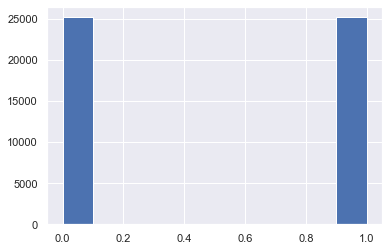

In [313]:
df_data.goal.hist()

In [325]:
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data['distance'] = df_data.apply(dist, axis=1)

In [335]:
corr = df_data.corr()

In [337]:
# target is the price
y_target_col = 'goal'
# Create a ranking of features correlated (+/-) with the target
relevant_features = np.abs(df_data.corr()[y_target_col]).sort_values(ascending=False)

#remove columns with NaN relevancy and the target
relevant_features = relevant_features[~relevant_features.isnull()].drop(index=y_target_col)

In [345]:
df_data[relevant_features[:10].index].columns

Index(['distance', 'st_x', 'sDist.1', 'Position_D', 'sDist', 'iSCF', 'BLK%',
       'G', 'ixG', 'IPP%'],
      dtype='object')

In [347]:
# use just 3 most correlated features
features = ['distance', 'st_x'] #, 'sDist.1', 'Position_D', 'sDist', 'iSCF', 'BLK%', 'G', 'ixG', 'IPP%']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test));
print(f'F1-score: {f1}')

Score: 0.660844250363901
F1-score: 0.6849028768133759
